In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import TruncatedSVD
from sinkhorn import sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Understanding how the truncated svd in scikitlearn works

In [86]:
X=np.random.rand(5,6)*100
X=np.round(X,0)

In [87]:
X

array([[34., 41.,  4., 39., 42., 32.],
       [71.,  6., 78., 19.,  6., 27.],
       [47., 82., 27., 62., 80., 76.],
       [89., 23., 40., 13., 13., 86.],
       [87., 44., 78., 30., 74., 44.]])

In [88]:
svd=TruncatedSVD(3) #choosing the rank r of the approximation, here a rank 3 approximation
US=svd.fit_transform(X)
V=svd.components_

In [89]:
np.round(US@V,2) #approximation of X

array([[26.31, 42.41,  9.8 , 31.53, 44.24, 37.87],
       [74.36,  3.82, 74.01,  7.56, 14.86, 27.31],
       [53.06, 80.02, 21.61, 59.66, 83.74, 72.98],
       [87.75, 23.77, 41.44, 16.85,  9.98, 85.96],
       [83.91, 45.94, 81.61, 39.94, 66.24, 43.83]])

### Initialisation of initial points 

## Test if low rank approximation improves the computational time

In [77]:
A=np.random.rand(100**2,100**2)
A=A*10000

In [78]:
np.linalg.matrix_rank(A, tol=None, hermitian=False)

10000

In [80]:
ones=np.ones(100**2)

In [81]:
start_time=time.time()
B=A@ones
end=time.time()-start_time

In [82]:
end

0.0626535415649414

In [83]:
svd=TruncatedSVD(500)
US=svd.fit_transform(A) 
V=svd.components_
start=time.time()
US@(V@ones)
end=time.time()-start

In [84]:
end

0.009865999221801758

It does really work !!!

### Sinkhorn where the rank of the rank approximation varies

In [95]:
# Points:
#n=100**2 #original number of datapoints, chose a lower one for runntime reasons 
n=100
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
x=x[:,np.newaxis]
y=y[:,np.newaxis]
# Cost:
C = (x-y.T)**2
# entropy factor:
eta = 1 # il manque W <- W/eta dans l'algo alors garder eta=1
# (exact) Kernel:
Kmat = np.exp(-eta*C)
#def K(v):  -----------#I have put them in comments since I won't use them 
#    return Kmat@v
#def Kt(v):
#    return (Kmat.T)@v
# Target marginals:
p = np.ones((n,1))
p = p / np.sum(p)
q = np.ones((n,1))
q = q / np.sum(q) 
# tolerance:
delta = 1e-15

In [96]:
rank_K=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)

In [97]:
rank_K

10

In [98]:
list_error=[]
list_time=[]
for i in range(1, 100):
    svd=TruncatedSVD(i)
    US=svd.fit_transform(Kmat) 
    V=svd.components_
    def K(v):
        return US@(V@v)
    def Kt(v):
        return V.T@(US.T@v)
    start_time=time.time()
    [_,_,_,_,_,err]=sinkhorn(K,Kt,p,q,delta,maxtime=60)
    execution_time=time.time()-start_time
    list_error.append(err[-1])
    list_time.append(execution_time)

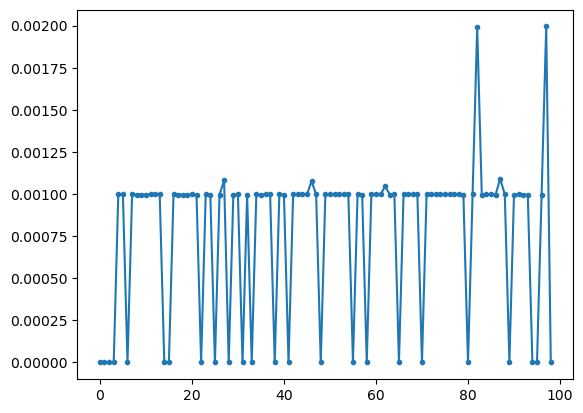

In [99]:
plt.plot(list_time, ".-")

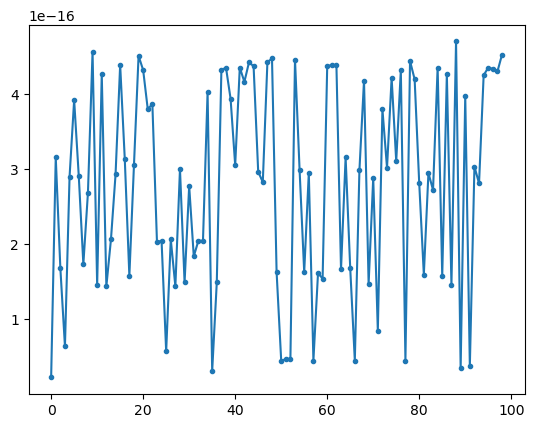

In [100]:
plt.plot(list_error, ".-")